In [1]:
import os
import pickle
from lib.methods import LoadCSV, PreProcessing, EchoStateNetwork, Figure
import warnings
warnings.simplefilter('ignore')

fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30
            })

In [2]:
os.chdir('../')

In [110]:
FILE_DIR = './data/VF_FVF_DATASETS/CSV/'
DATA_NAME = 'MRI8_NVF4_10mm_0p0mmVVV'
ADDITIONAL_PATH = ''
SAMPLE_SPAN = [160000, 180000]
FILTER_METHOD = 'bandpass_filtering'
BANDPASS_PARAMS = {
                'passband_edge_freq':[100, 350], 
                'stopband_edge_freq':[20, 800], 
                'passband_edge_max_loss':1, 
                'stopband_edge_min_loss':40
                }
ESN_PARAMS = {
            'units':500, 
            'SR':0.001, 
            'input_shape':10, 
            'output_shape':10, 
            'W_in_scale':0.1, 
            'W_res_density':0.1, 
            'leak_rate':1.0, 
            'alpha':0.0005, 
            'seed':0
            }
TRAIN_TEST_DATA_PARAMS = {
                        'n_shift':10,
                        'n_dimension':10,
                        'n_train':5000,
                        'n_predstep':1
                        }
MODEL_DIR = './results/esn_model/'

In [68]:
FILE_DIR = './data/VF_FVF_DATASETS/CSV/'
DATA_NAME = 'MRI8_NVF4_10mm_0p0mmVVVV'
ADDITIONAL_PATH = ''
SAMPLE_SPAN = [160000, 180000]
FILTER_METHOD = 'bandpass_filtering'
BANDPASS_PARAMS = {
                'passband_edge_freq':[100, 450], 
                'stopband_edge_freq':[50, 800], 
                'passband_edge_max_loss':1, 
                'stopband_edge_min_loss':20
                }
ESN_PARAMS = {
            'units':800, 
            'SR':1.5, 
            'input_shape':10, 
            'output_shape':10, 
            'W_in_scale':0.1, 
            'W_res_density':0.1, 
            'leak_rate':1.0, 
            'alpha':0.001, 
            'seed':0
            }
TRAIN_TEST_DATA_PARAMS = {
                        'n_shift':10,
                        'n_dimension':10,
                        'n_train':5000,
                        'n_predstep':1
                        }
MODEL_DIR = './results/esn_model/'

In [9]:
[t_data, mic_data] = LoadCSV(
                            file_path=FILE_DIR+DATA_NAME+ADDITIONAL_PATH+'.csv',
                            data_name_list=['t', 'mic'],
                            sample_span=[0, None]
                            )

Loading csv data
file path | ./data/VF_FVF_DATASETS/CSV/MRI8_NVF4_10mm_0p0mmVVVV.csv
data list | t, mic


In [10]:
preprocess = PreProcessing(data=mic_data, t_data=t_data)
preprocess.filter(method=FILTER_METHOD, params=BANDPASS_PARAMS)
preprocess.cut(span=SAMPLE_SPAN, new_t=False)
preprocess.embed(n_shift=TRAIN_TEST_DATA_PARAMS['n_shift'], n_dimension=TRAIN_TEST_DATA_PARAMS['n_dimension'])
train_X, train_Y, test_X, test_Y = preprocess.train_test_split(
                                                            n_train=TRAIN_TEST_DATA_PARAMS['n_train'], 
                                                            n_predstep=TRAIN_TEST_DATA_PARAMS['n_predstep']
                                                            )
train_t = preprocess.t_data[TRAIN_TEST_DATA_PARAMS['n_predstep']:TRAIN_TEST_DATA_PARAMS['n_predstep']+train_Y.shape[0]]
test_t = preprocess.t_data[TRAIN_TEST_DATA_PARAMS['n_train']+TRAIN_TEST_DATA_PARAMS['n_predstep']:TRAIN_TEST_DATA_PARAMS['n_train']+TRAIN_TEST_DATA_PARAMS['n_predstep']+test_Y.shape[0]]

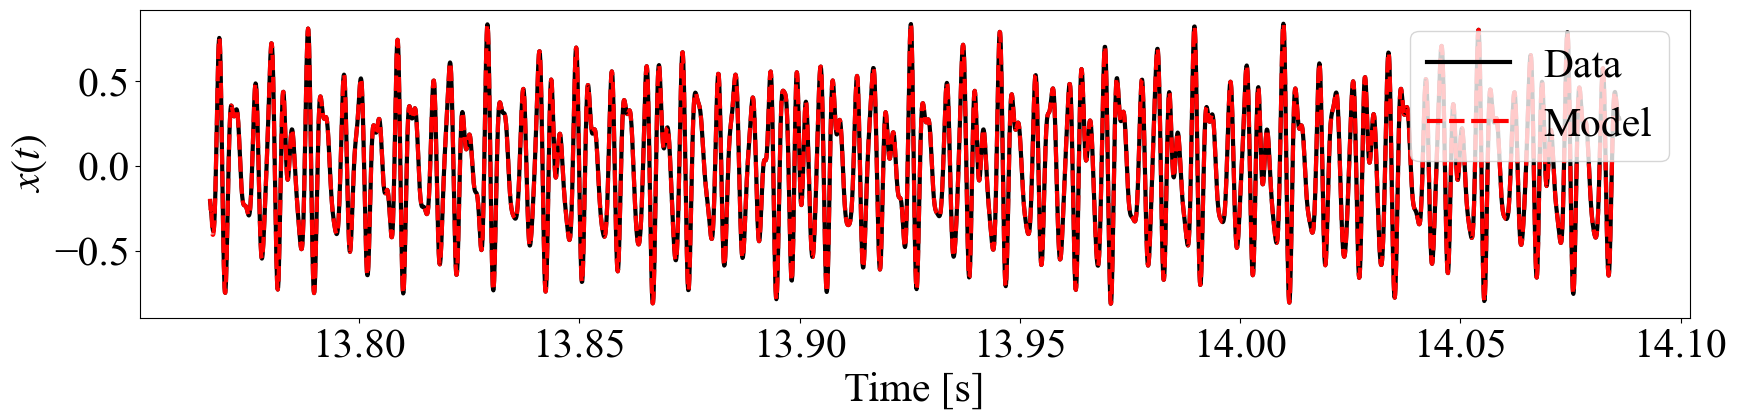

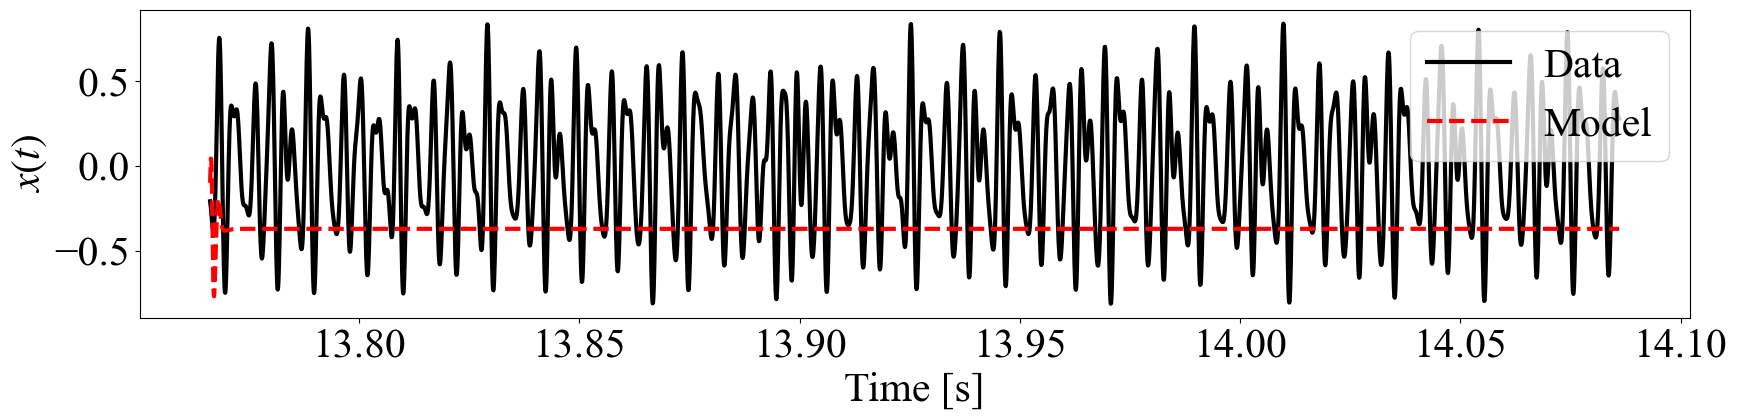

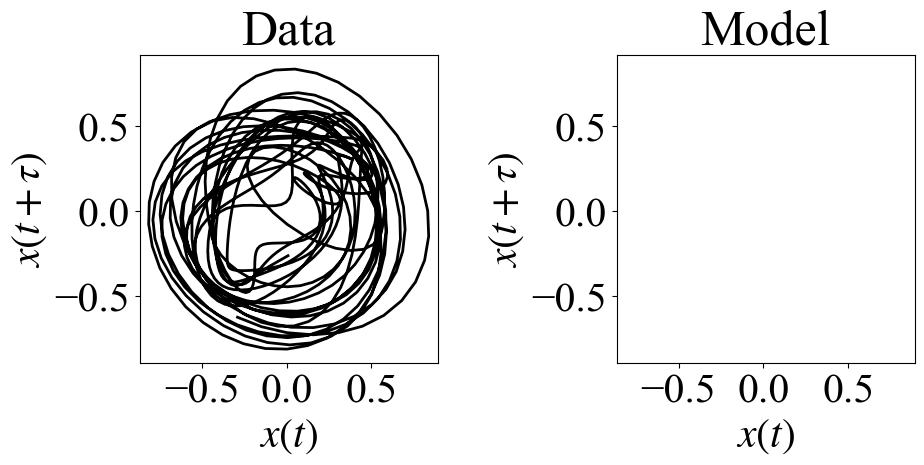

In [101]:
esn = EchoStateNetwork(
                    units=ESN_PARAMS['units'], 
                    SR=ESN_PARAMS['SR'], 
                    input_shape=ESN_PARAMS['input_shape'], 
                    output_shape=ESN_PARAMS['output_shape'], 
                    W_in_scale=ESN_PARAMS['W_in_scale'], 
                    W_res_density=ESN_PARAMS['W_res_density'], 
                    leak_rate=ESN_PARAMS['leak_rate'], 
                    alpha=ESN_PARAMS['alpha'], 
                    seed=ESN_PARAMS['seed']
                    )

esn.fit(in_layer_data=train_X, out_layer_data=train_Y)

pred_test_Y = esn.predict(test_X)
fig.plt_timeseries_of_data_and_model(test_Y[:, 0, 0], pred_test_Y[:, 0], test_t, 4000)

n_freerun = 5000
freerun_test_Y = esn.freerun(in_layer_data0=test_X[0], pred_range=n_freerun, return_reservoir=False)
fig.plt_timeseries_of_data_and_model(test_Y[:, 0, 0], freerun_test_Y[:, 0], test_t, 4000)
fig.plt_attractor_of_data_and_model(test_Y[1000:, 0, 0], freerun_test_Y[1000:, 0], 1000, 9, './results/MRI8_NVF4_10mm_0p0mmVVVV/test.png')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

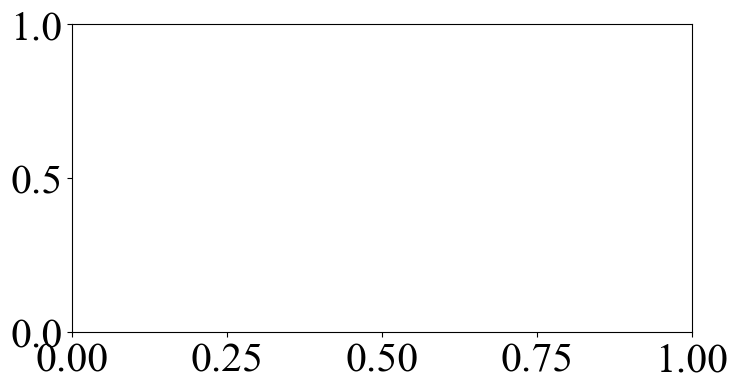

In [112]:
lyapunov_exponents, dims = esn.computing_lyapunov_exponent(dt=t_data[1]-t_data[0])
fig.plt_lyapunov_exponents(lyapunov_exponents)

In [113]:
pickle.dump(esn, open(MODEL_DIR+DATA_NAME+'.pkl', "wb"))

In [102]:
import numpy as np
alphas = np.arange(0.0001, 1.006, 0.0001)
alphas = np.round(alphas[np.where(np.round(alphas % 0.005, 4) == 0)], decimals=3)

count = 1

for units in range(500, 1501):
    for SR in np.round(np.arange(0.1, 2.1, 0.1), decimals=1):
        for alpha in alphas:
            ESN_PARAMS = {
            'units':units, 
            'SR':SR, 
            'input_shape':10, 
            'output_shape':10, 
            'W_in_scale':0.1, 
            'W_res_density':0.1, 
            'leak_rate':1.0, 
            'alpha':alpha, 
            'seed':0
            }
            print('try: '+str(count))
            print('units='+str(units))
            print('SR='+str(SR))
            print('alpha='+str(alpha))
            esn = EchoStateNetwork(
                    units=ESN_PARAMS['units'], 
                    SR=ESN_PARAMS['SR'], 
                    input_shape=ESN_PARAMS['input_shape'], 
                    output_shape=ESN_PARAMS['output_shape'], 
                    W_in_scale=ESN_PARAMS['W_in_scale'], 
                    W_res_density=ESN_PARAMS['W_res_density'], 
                    leak_rate=ESN_PARAMS['leak_rate'], 
                    alpha=ESN_PARAMS['alpha'], 
                    seed=ESN_PARAMS['seed']
                    )
            esn.fit(in_layer_data=train_X, out_layer_data=train_Y)
            n_freerun = 5000
            freerun_test_Y = esn.freerun(in_layer_data0=test_X[0], pred_range=n_freerun, return_reservoir=False)
            fig.plt_attractor_of_data_and_model(test_Y[1000:, 0, 0], freerun_test_Y[1000:, 0], 1000, 9, './results/MRI8_NVF4_10mm_0p0mmVVVV/'+str(count)+'.png')
            count = count+1

try: 1
units=500
SR=0.1
alpha=0.005


try: 2
units=500
SR=0.1
alpha=0.01


try: 3
units=500
SR=0.1
alpha=0.02


try: 4
units=500
SR=0.1
alpha=0.025


try: 5
units=500
SR=0.1
alpha=0.03


try: 6
units=500
SR=0.1
alpha=0.035


try: 7
units=500
SR=0.1
alpha=0.04


try: 8
units=500
SR=0.1
alpha=0.045


try: 9
units=500
SR=0.1
alpha=0.05


try: 10
units=500
SR=0.1
alpha=0.055


try: 11
units=500
SR=0.1
alpha=0.06


try: 12
units=500
SR=0.1
alpha=0.065


try: 13
units=500
SR=0.1
alpha=0.07


try: 14
units=500
SR=0.1
alpha=0.075


try: 15
units=500
SR=0.1
alpha=0.08


try: 16
units=500
SR=0.1
alpha=0.085


try: 17
units=500
SR=0.1
alpha=0.09


try: 18
units=500
SR=0.1
alpha=0.1


try: 19
units=500
SR=0.1
alpha=0.105


try: 20
units=500
SR=0.1
alpha=0.11


try: 21
units=500
SR=0.1
alpha=0.115


try: 22
units=500
SR=0.1
alpha=0.12


try: 23
units=500
SR=0.1
alpha=0.13


Learning:  63%|██████▎   | 3083/4909 [00:04<00:02, 678.18it/s]